In this notebook, we will forecast the traffic speed on the PeMSD7 dataset using a LightGBM model. The PeMSD7 dataset can be found here:
- [PeMSD7 dataset](https://github.com/VeritasYin/STGCN_IJCAI-18/tree/master/dataset)

The dataset holds traffic speed data from 228 sensors over a period of 2 months (only weekdays) in 5 minute intervals. We will split the data into a training (1/first month), validation (half-a-month), and test (last half-a-month) dataset like it is commonly done in literature. Here, we will predict the next 15 min (= 3 time steps). Boosted tree models have (at times) been found to be very competetive for time series forecasting. However, they mostly shine at highly hierachical datasets, e.g. imagine a demand forecasting problems with a lot product categories / country categories or similiar. The PeMSD7 dataset is not really highly hierachical. Moreover, the time series from different sensors in the PeMSD7 dataset are somewhat correlated, e.g. traffic that passes a sensor on one road will appear some minutes later on a sensor on the same road but further down. A LightGBM model might not really shine on this type of data. On such datasets vector autoregressive models (VAR) or temporal graph neural networks might be better suited. One of the earliest papers on temporal graph neural networks:
- [Yu et al. Spatio-Temporal Graph Convolutional Networks: A Deep Learning Framework
for Traffic Forecasting. **2018**](https://www.ijcai.org/proceedings/2018/0505.pdf)

achieves a MAE error of 2.25 on the PeMSD7 dataset (for the same task of predicting the next 15 min as done in this notebook as well).

Even though as discussed, boosted trees might not be perfectly suited candidates for the PeMSD7 dataset on paper, we will try this out in this notebook. I will hopefully come back in sometime to to compare the results of this notebook against VAR models and more modern temporal graph neural networks.

Let's start. We will load the dataset, add timestamps manually, and split it into training, validation, and test data as described above

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta, datetime
from itertools import product
import matplotlib.pyplot as plt
import warnings
from time import time
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error
from functools import wraps
import random
import math
from copy import deepcopy
import optuna
from functools import partial
import shap
import matplotlib.ticker as ticker
import zipfile
import urllib

optuna.logging.set_verbosity(optuna.logging.WARNING)
warnings.simplefilter(action="ignore", category=DeprecationWarning)
plt.rcParams["figure.dpi"] = 300
plt.rcParams["xtick.labelsize"] = 5
plt.rcParams["ytick.labelsize"] = 5
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 1000)

zip_path, _ = urllib.request.urlretrieve(
    "https://github.com/VeritasYin/STGCN_IJCAI-18/raw/master/dataset/PeMSD7_Full.zip")

with zipfile.ZipFile(zip_path, "r") as f:
    f.extractall("./data/")

adj_matrix = pd.read_csv("./data/PeMSD7_W_228.csv", header=None).to_numpy()
df = pd.read_csv("./data/PeMSD7_V_228.csv", header=None)
df_station = pd.read_csv("https://raw.githubusercontent.com/VeritasYin/STGCN_IJCAI-18/master/dataset/PeMSD7_M_Station_Info.csv", index_col=False)
df_station = df_station.rename({"Unnamed: 0": "sensor_id"}, axis="columns")
df_station = df_station.drop(
    columns=["ID", "Fwy", "Dir", "District", "Latitude", "Longitude"])

# weekdays of May and June of 2012.
dt_start = datetime(2012, 5, 1)
dt_end = datetime(2012, 7, 1)
increment = timedelta(minutes=5)

workdays = [
    dt_start + timedelta(days=x) for x in range((dt_end - dt_start).days)
    if not ((dt_start + timedelta(days=x)).weekday() in [5, 6])]
df["dt"] = np.array([dt + increment * idx for (dt, idx) in product(
    workdays, range(timedelta(days=1) // timedelta(minutes=5)))])

df_train = df.loc[:(df["dt"] >=  datetime(2012, 6, 1)).idxmax(), :]
df_val = df.loc[(df["dt"] >=  datetime(2012, 6, 1)).idxmax():
                (df["dt"] >=  datetime(2012, 6, 16)).idxmax() - 1, :]
df_test = df.loc[(df["dt"] >=  datetime(2012, 6, 16)).idxmax():, :]

print(df_train.loc[:, 0:5].head(n=3))

C:\Users\User\anaconda3\envs\ts-now\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


      0     1     2     3     4     5
0  71.1  66.0  64.6  65.6  67.1  71.9
1  68.1  66.8  61.7  66.7  64.5  71.6
2  68.0  64.3  66.6  68.7  68.1  70.5


Now we will transform the dataset from it series format into a tabular format that LightGBM can handle. We will add lags for the last 6 time points for each entry. Additionally, we will introduce 4 lags with a lag of ~1 day. It should be intuitive that one can expect a daily seasonality in this data and I will also show in the next cell that this is actually the case:

In [2]:
def add_lag_features(
        X, y, lag_col, lags, new_feat_names, lag_X=False, lag_y=False):   
    X_, y_ = deepcopy(X), deepcopy(y)
    for lag, name in zip(lags, new_feat_names):
        if lag_X:
            X_.loc[:, [name]] = X_.groupby("sensor_id").shift(
                lag).loc[:, [lag_col]].values
        elif lag_y:
            y_.loc[:, [name]] = y_.groupby("sensor_id").shift(
                -lag).loc[:, [lag_col]].values

    try:
        idx_X = X_.loc[:, new_feat_names].isna().any(axis=1).values
    except:
        idx_X = np.full((len(X_),), False)
    try:
        idx_y = y_.loc[:, new_feat_names].isna().any(axis=1).values
    except:
        idx_y = np.full((len(y_),), False)

    X_ = X_.loc[~(idx_X | idx_y), :].reset_index(drop=True)
    y_ = y_.loc[~(idx_X | idx_y), :].reset_index(drop=True)
    return X_, y_


def transform_ts_to_tabular(df, horizon_len, delay):
    X = df.melt(
        id_vars=["dt"], var_name="sensor_id", value_vars=list(range(228)), 
        value_name="t0")    
    X, y = add_lag_features(
        X, deepcopy(X), "t0", list(range(1+delay, horizon_len+1+delay)), 
        [f"t+{i}" for i in range(1, horizon_len+1)], lag_y=True)
    y = y.drop(columns=["dt", "sensor_id", "t0"])
    return X, y


horizon_len = 3
context_len = 6
delay = 0

X_train, y_train = transform_ts_to_tabular(df_train, horizon_len, delay)
X_val, y_val = transform_ts_to_tabular(df_val, horizon_len, delay)
X_test, y_test = transform_ts_to_tabular(df_test, horizon_len, delay)

lags = list(range(1, context_len)) + [12*24-3, 12*24-2, 12*24-1, 12*24]
lag_names = [f"t{-i}" for i in range(1, context_len)] + ["t-23_45h", "t-23_50h", "t-23_55h", "t-24_00h"]

X_train, y_train = add_lag_features(
    X_train, y_train, "t0", lags, lag_names, lag_X=True)
X_val, y_val = add_lag_features(
    X_val, y_val, "t0", lags, lag_names, lag_X=True)
X_test, y_test = add_lag_features(
    X_test, y_test, "t0", lags, lag_names, lag_X=True)

print(X_train.head(n=3))
print(y_train.head(n=3))

                   dt sensor_id    t0   t-1   t-2   t-3   t-4   t-5  t-23_45h  t-23_50h  t-23_55h  t-24_00h
0 2012-05-02 00:00:00         0  72.0  70.2  71.9  70.8  72.1  70.7      68.3      68.0      68.1      71.1
1 2012-05-02 00:05:00         0  72.6  72.0  70.2  71.9  70.8  72.1      68.9      68.3      68.0      68.1
2 2012-05-02 00:10:00         0  71.8  72.6  72.0  70.2  71.9  70.8      66.6      68.9      68.3      68.0
    t+1   t+2   t+3
0  72.6  71.8  69.3
1  71.8  69.3  68.0
2  69.3  68.0  70.3


Now I will demonstrate that there is a daily seasonality in the data (by looking at the sensor with the ID 0). Interestingly enough, there is also a seasonality of ~8 h ~12 h which may be attributed to people going and coming back from work. But we will ignore this here and not add any lag features for this: 

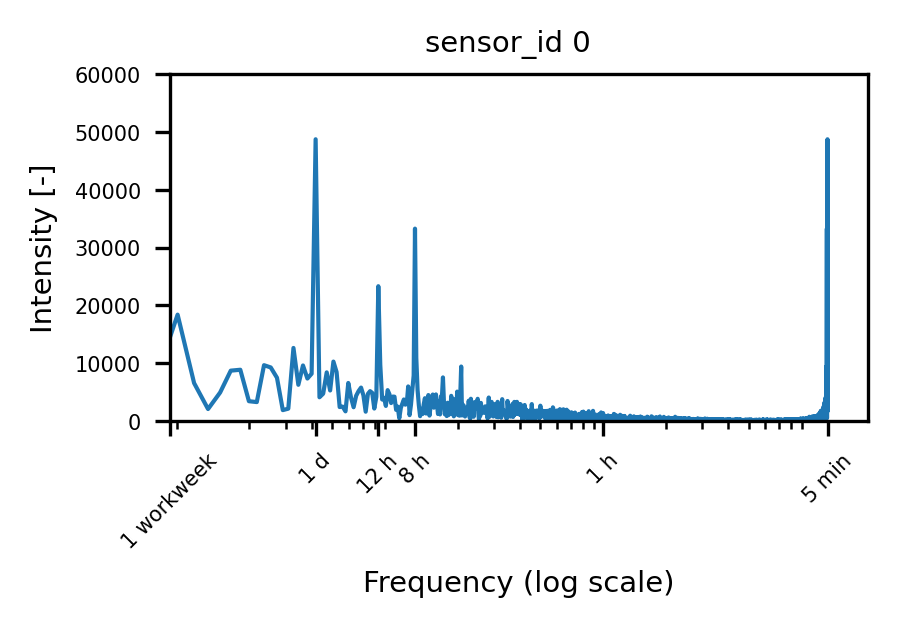

In [3]:
sensor_id = 0 
fft = np.fft.fft(df_train.loc[:, sensor_id].values)

f_per_dataset = np.arange(0, fft.shape[0])
f_per_hour = fft.shape[0] / 12

fig, ax = plt.subplots(figsize=(3, 1.5))
ax.plot(f_per_dataset / f_per_hour, np.abs(fft), linewidth=1)
ax.set_xscale("log")
ax.set_ylim(0, 6e4)
ax.set_xlim([0.1, max(plt.xlim())])
ax.set_xticks([12, 1, 1/8, 1/12, 1/24, 1/(24*5)])
ax.set_xticklabels(
    labels=["5 min", "1 h", "8 h", "12 h", "1 d", "1 workweek"], rotation=45)

ax.set_xlabel("Frequency (log scale)", fontsize=7)
ax.set_ylabel("Intensity [-]", fontsize=7)
fig.suptitle(f"sensor_id {sensor_id}", fontsize=7)
plt.show()

Moreover as discussed above, one can expect that traffic which passes a sensor on one road will appear some minutes later on a sensor on the same road but further down. In the next cell, for every sensor we look at the next closest and second closest sensor to see if we can find any cross correlation between the source and neighboring sensors at different lags: 

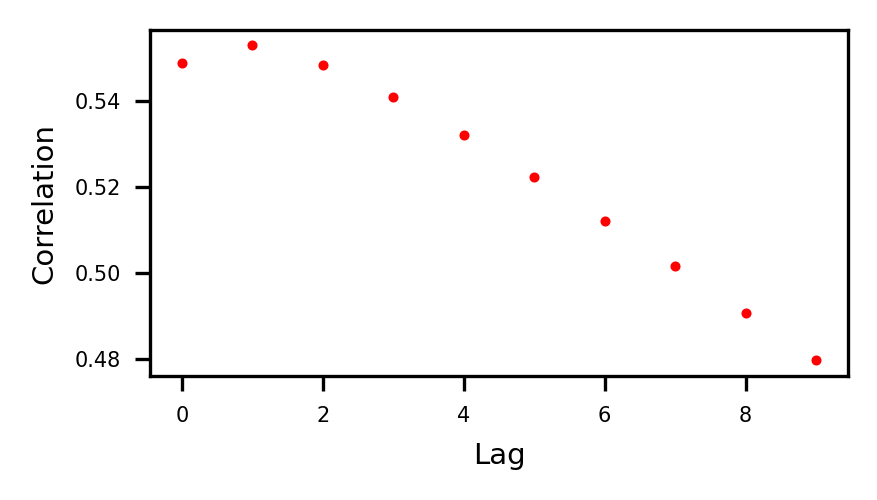

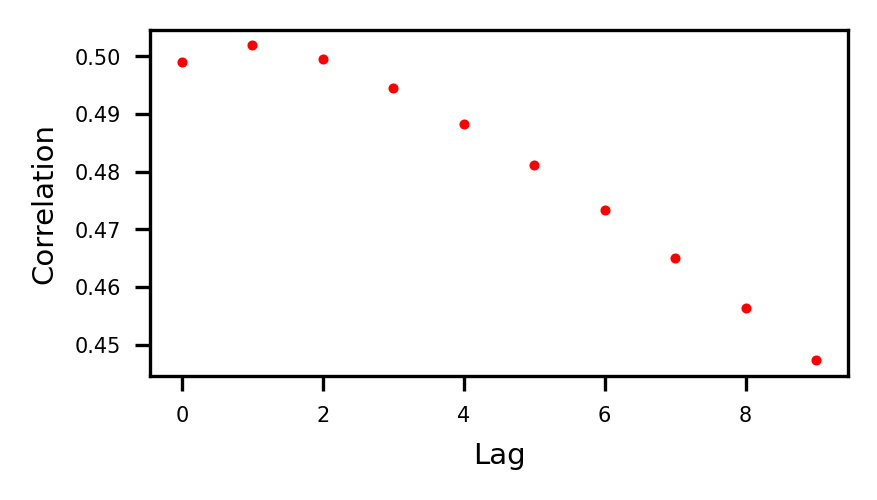

In [4]:
def prepare_df_stations(df_station, adj_matrix, n_neighbors):
    df = deepcopy(df_station)
    for idx in range(n_neighbors):
        df[f"sensor_id_neighbor{idx}"] = np.nan
    
    for idx0, cur_id in enumerate(df["sensor_id"]):
        id_neighbors = np.argsort(adj_matrix[:, cur_id])[1:1+n_neighbors]
        for idx1, id_neighbor in enumerate(id_neighbors):
            df.loc[idx0, f"sensor_id_neighbor{idx1}"] = id_neighbor
    return df


def add_neighbor_features(X, y, df_station, adj_matrix, n_neighbors, lags):    
    df_station_ = prepare_df_stations(df_station, adj_matrix, n_neighbors)
    X = X.merge(df_station_, on=["sensor_id"])
    for idx0 in range(n_neighbors):
        lag_names = [f"t{-idx1}_neighbor{idx0}" for idx1 in lags]
        X_, y_ = add_lag_features(X, y, "t0", lags, lag_names, lag_X=True) 
        X = pd.merge(
            X, 
            X_.loc[:, ["dt", "sensor_id"] + lag_names], 
            how="left", left_on=["dt", f"sensor_id_neighbor{idx0}"], 
            right_on=["dt", "sensor_id"], 
            suffixes=["", f"_neighbor{idx0}"]
            )
        X = X.loc[:, ~X.columns.duplicated()]
        
    idx_to_drop = X.loc[:, lag_names].isna().any(axis=1).values
    X = X.loc[~idx_to_drop, :].reset_index(drop=True)
    y = y.loc[~idx_to_drop, :].reset_index(drop=True)
                   
    X = X.drop(columns=[f"sensor_id_neighbor{i}" for i in range(n_neighbors)])
    return X, y


def crosscorr(X, y, lags, display=True):
    df = pd.DataFrame.from_records({
        "lag": lags, "corr": np.zeros((lags.shape[0],))})
    for idx, lag in enumerate(lags):
        df.loc[idx, ["corr"]] = X.corr(y.shift(lag))
    
    fig, ax = plt.subplots(figsize=(3, 1.5))
    ax.scatter(lags, df["corr"], color="red", s=2)
    ax.set_ylabel("Correlation", fontsize=7)
    ax.set_xlabel("Lag", fontsize=7)
    plt.show()
    return df

X_train_tmp, y_train_tmp = add_neighbor_features(
    X_train, y_train, df_station, adj_matrix, 3, np.arange(0, 1))

_ = crosscorr(X_train_tmp["t0_neighbor0"], y_train_tmp["t+1"], lags=np.arange(0, 10))
_ = crosscorr(X_train_tmp["t0_neighbor1"], y_train_tmp["t+1"], lags=np.arange(0, 10))

From the plots above, it is apparent that we see some correlation between neighboring sensors. Therefore, we will add to each row some lags of the closest two neighbors as well. In the end, we will try to figure out if this provided any added benefits. Though there is crosscorrelation, this way of adding this information is somewhat unspecific to what a temporal graph neural network (GNN) might potentially learn. A temporal GNN might decide here to learn adaptively from more (or less) neighbors and also specific associations (e.g., a sensor might be close to another but located on a road that has no intersection to the road of the other sensor).

In [5]:
n_neighbors = 2

X_train, y_train = add_neighbor_features(
    X_train, y_train, df_station, adj_matrix, n_neighbors, np.arange(1, 4))
X_val, y_val = add_neighbor_features(
    X_val, y_val, df_station, adj_matrix, n_neighbors, np.arange(1, 4))
X_test, y_test = add_neighbor_features(
    X_test, y_test, df_station, adj_matrix, n_neighbors, np.arange(1, 4))

print(X_train.head(n=3))

                   dt sensor_id    t0   t-1   t-2   t-3   t-4   t-5  t-23_45h  t-23_50h  t-23_55h  t-24_00h  t-1_neighbor0  t-2_neighbor0  t-3_neighbor0  t-1_neighbor1  t-2_neighbor1  t-3_neighbor1
0 2012-05-02 00:15:00         0  69.3  71.8  72.6  72.0  70.2  71.9      65.8      66.6      68.9      68.3           69.3           68.6           68.1           69.8           69.0           67.9
1 2012-05-02 00:20:00         0  68.0  69.3  71.8  72.6  72.0  70.2      68.3      65.8      66.6      68.9           68.3           69.3           68.6           69.4           69.8           69.0
2 2012-05-02 00:25:00         0  70.3  68.0  69.3  71.8  72.6  72.0      69.2      68.3      65.8      66.6           68.7           68.3           69.3           70.1           69.4           69.8


Furthermore, we we will add the day of the week and the hour of the day as categorical features:

In [6]:
def dt_encoding(df):
    df["weekday"] = df["dt"].map(lambda x: x.timetuple().tm_wday)
    df["hour"] = df["dt"].map(lambda x: x.timetuple().tm_hour)
    df = df.drop(columns=["dt"])
    return df


X_train = dt_encoding(X_train)
X_val = dt_encoding(X_val)
X_test = dt_encoding(X_test)

print(X_train.head(n=3))

  sensor_id    t0   t-1   t-2   t-3   t-4   t-5  t-23_45h  t-23_50h  t-23_55h  t-24_00h  t-1_neighbor0  t-2_neighbor0  t-3_neighbor0  t-1_neighbor1  t-2_neighbor1  t-3_neighbor1  weekday  hour
0         0  69.3  71.8  72.6  72.0  70.2  71.9      65.8      66.6      68.9      68.3           69.3           68.6           68.1           69.8           69.0           67.9        2     0
1         0  68.0  69.3  71.8  72.6  72.0  70.2      68.3      65.8      66.6      68.9           68.3           69.3           68.6           69.4           69.8           69.0        2     0
2         0  70.3  68.0  69.3  71.8  72.6  72.0      69.2      68.3      65.8      66.6           68.7           68.3           69.3           70.1           69.4           69.8        2     0


We have three categorical columns in our data ("sensor_id", "weekday", "hour"). With LightGBM it is not necessary to expressively one-hot encode these - by simple changing the datatype of these columns to "category" LightGBM will automatically take care of that for us: 

In [7]:
for col in (["sensor_id", "weekday", "hour"]):
    X_train[col] = X_train[col].astype("category")
    X_val[col] = X_val[col].astype("category")
    X_test[col] = X_test[col].astype("category")

To speed up training, we will downsample a bit and only use every 12th row:

In [8]:
roll_ts = 12
X_train0 = X_train.loc[::roll_ts, :].reset_index(drop=True)
y_train0 = y_train.loc[::roll_ts, :].reset_index(drop=True)
X_val0 = X_val.loc[::roll_ts, :].reset_index(drop=True)
y_val0 = y_val.loc[::roll_ts, :].reset_index(drop=True)
X_test0 = X_test.loc[::roll_ts, :].reset_index(drop=True)
y_test0 = y_test.loc[::roll_ts, :].reset_index(drop=True)

In this notebook, we are trying to predict the next 3 time steps. Boosted tree models are incapable of directly predicting multiple time steps at once. There are two workarounds to deal with this. The *recursive* method, in that we predict only the next time step and then add this predicted value to our time series and predict the next time step and so on. This has the obvious drawback that it leads to an accumulation of errors. The *direct* method simply trains one boosted tree model for each time step that is to be predict. This has the obvious drawback of having to train multiple models (and therefore longer) and then also having to deploy multiple models. We will use the *direct* method here. We optimize hyperparameters using Bayesian optimization as provided by the optuna package. So let's start training:

In [9]:
def timeit(func):
    @wraps(func)
    def timeit_wrapper(*args, **kwargs):
        time_start = time()
        result = func(*args, **kwargs)
        time_end = time()
        print(f"Elapsed time: {(time_end-time_start)/60:.1f} min")
        return result
    return timeit_wrapper


def objective(trial, X_train, y_train, X_val, y_val, idx_horizon):
    learning_rate = trial.suggest_float("learning_rate", 0.001, 0.1, log=True)
    min_child_samples = trial.suggest_int("min_child_samples", 4, 100)
    num_leaves = trial.suggest_int("num_leaves", 21, 101)
    max_depth = trial.suggest_int("max_depth", 4, 151)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.2, 1.0)
    early_stopping_round = trial.suggest_int("early_stopping_round", 4, 101)
    reg_alpha = trial.suggest_float("reg_alpha ", 0.0, 0.4)
    reg_lambda = trial.suggest_float("reg_lambda ", 0.0, 0.4)
    
    regressor = LGBMRegressor(
        learning_rate=learning_rate, 
        min_child_samples=min_child_samples,
        num_leaves=num_leaves, 
        max_depth=max_depth, 
        colsample_bytree=colsample_bytree,
        early_stopping_round=early_stopping_round,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda,
        objective="mae", 
        verbosity=-1, 
        n_estimators=20000, 
        n_jobs=-1)
    model = regressor.fit(
        X_train, y_train.iloc[:, idx_horizon:idx_horizon+1], 
        eval_set=[(X_val, y_val.iloc[:, idx_horizon:idx_horizon+1])],
        eval_metric="mae")
            
    return model.best_score_["valid_0"]["l1"]
 

@timeit   
def train_direct_multihorizon_models(
        X_train, y_train, X_val, y_val, horizon_len, n_trials): 
    models = []
    pars = []
    metrics = []

    for idx_horizon in range(horizon_len):
        _objective = partial(objective, X_train=X_train, y_train=y_train, 
                            X_val=X_val, y_val=y_val, idx_horizon=idx_horizon)
        study = optuna.create_study(direction="minimize")
        study.optimize(_objective, n_trials=n_trials)
        pars.append(study.best_trial.params)
        # optuna.visualization.matplotlib.plot_optimization_history(study)
        
    for idx_horizon in range(horizon_len):
        regressor = LGBMRegressor(
            **pars[idx_horizon],
            objective="mae", 
            verbosity=-1, 
            n_estimators=15000, 
            n_jobs=-1)
        regressor.fit(
            X_train, y_train.iloc[:, idx_horizon:idx_horizon+1],
            eval_set=[(X_val, y_val.iloc[:, idx_horizon:idx_horizon+1])],
            eval_metric="mae")
        models.append(regressor)
        metrics.append(regressor.best_score_["valid_0"]["l1"])
    return models, pars, metrics

    
models0, pars0, metrics0 = train_direct_multihorizon_models(
        X_train0, y_train0, X_val0, y_val0, horizon_len, n_trials=50)
    
tmp0 = [[f"({k}, {v:.3f})" for k, v in x.items()] for x in pars0]
_ = [print(f"Forecast horizon: {idx}\nParameters: {x}",) for idx, x in enumerate(tmp0)]
_ = [print(f"Forecast horizon: {idx}\nMAE best model: {x:.3f}",) for idx, x in enumerate(metrics0)]

Elapsed time: 121.3 min
Forecast horizon: 0
Parameters: ['(learning_rate, 0.008)', '(min_child_samples, 91.000)', '(num_leaves, 44.000)', '(max_depth, 120.000)', '(colsample_bytree, 0.296)', '(early_stopping_round, 87.000)', '(reg_alpha , 0.044)', '(reg_lambda , 0.364)']
Forecast horizon: 1
Parameters: ['(learning_rate, 0.007)', '(min_child_samples, 87.000)', '(num_leaves, 76.000)', '(max_depth, 55.000)', '(colsample_bytree, 0.303)', '(early_stopping_round, 94.000)', '(reg_alpha , 0.005)', '(reg_lambda , 0.320)']
Forecast horizon: 2
Parameters: ['(learning_rate, 0.014)', '(min_child_samples, 69.000)', '(num_leaves, 52.000)', '(max_depth, 124.000)', '(colsample_bytree, 0.318)', '(early_stopping_round, 33.000)', '(reg_alpha , 0.296)', '(reg_lambda , 0.153)']
Forecast horizon: 0
MAE best model: 1.305
Forecast horizon: 1
MAE best model: 1.828
Forecast horizon: 2
MAE best model: 2.236


Now let's evaluate how our model performs on the test data:

In [10]:
@timeit
def pred_multihorizon_direct(df, models):
    y_pred = np.zeros((len(df), len(models)))
    for idx0 in range(len(models)):
        y_pred[:, idx0] = models[idx0].predict(df)
    return y_pred
    

y_test_pred0 = pred_multihorizon_direct(X_test0, models0)
mae_test0 = mean_absolute_error(y_test0.values, y_test_pred0)
print(f"MAE test: {mae_test0:.2f}")

Elapsed time: 0.4 min
MAE test: 1.77


Despite intuition, it looks like our LightGBM model might be competetive against temporal graph neural networks.

Furthermore, let's have a look at a few predictions:

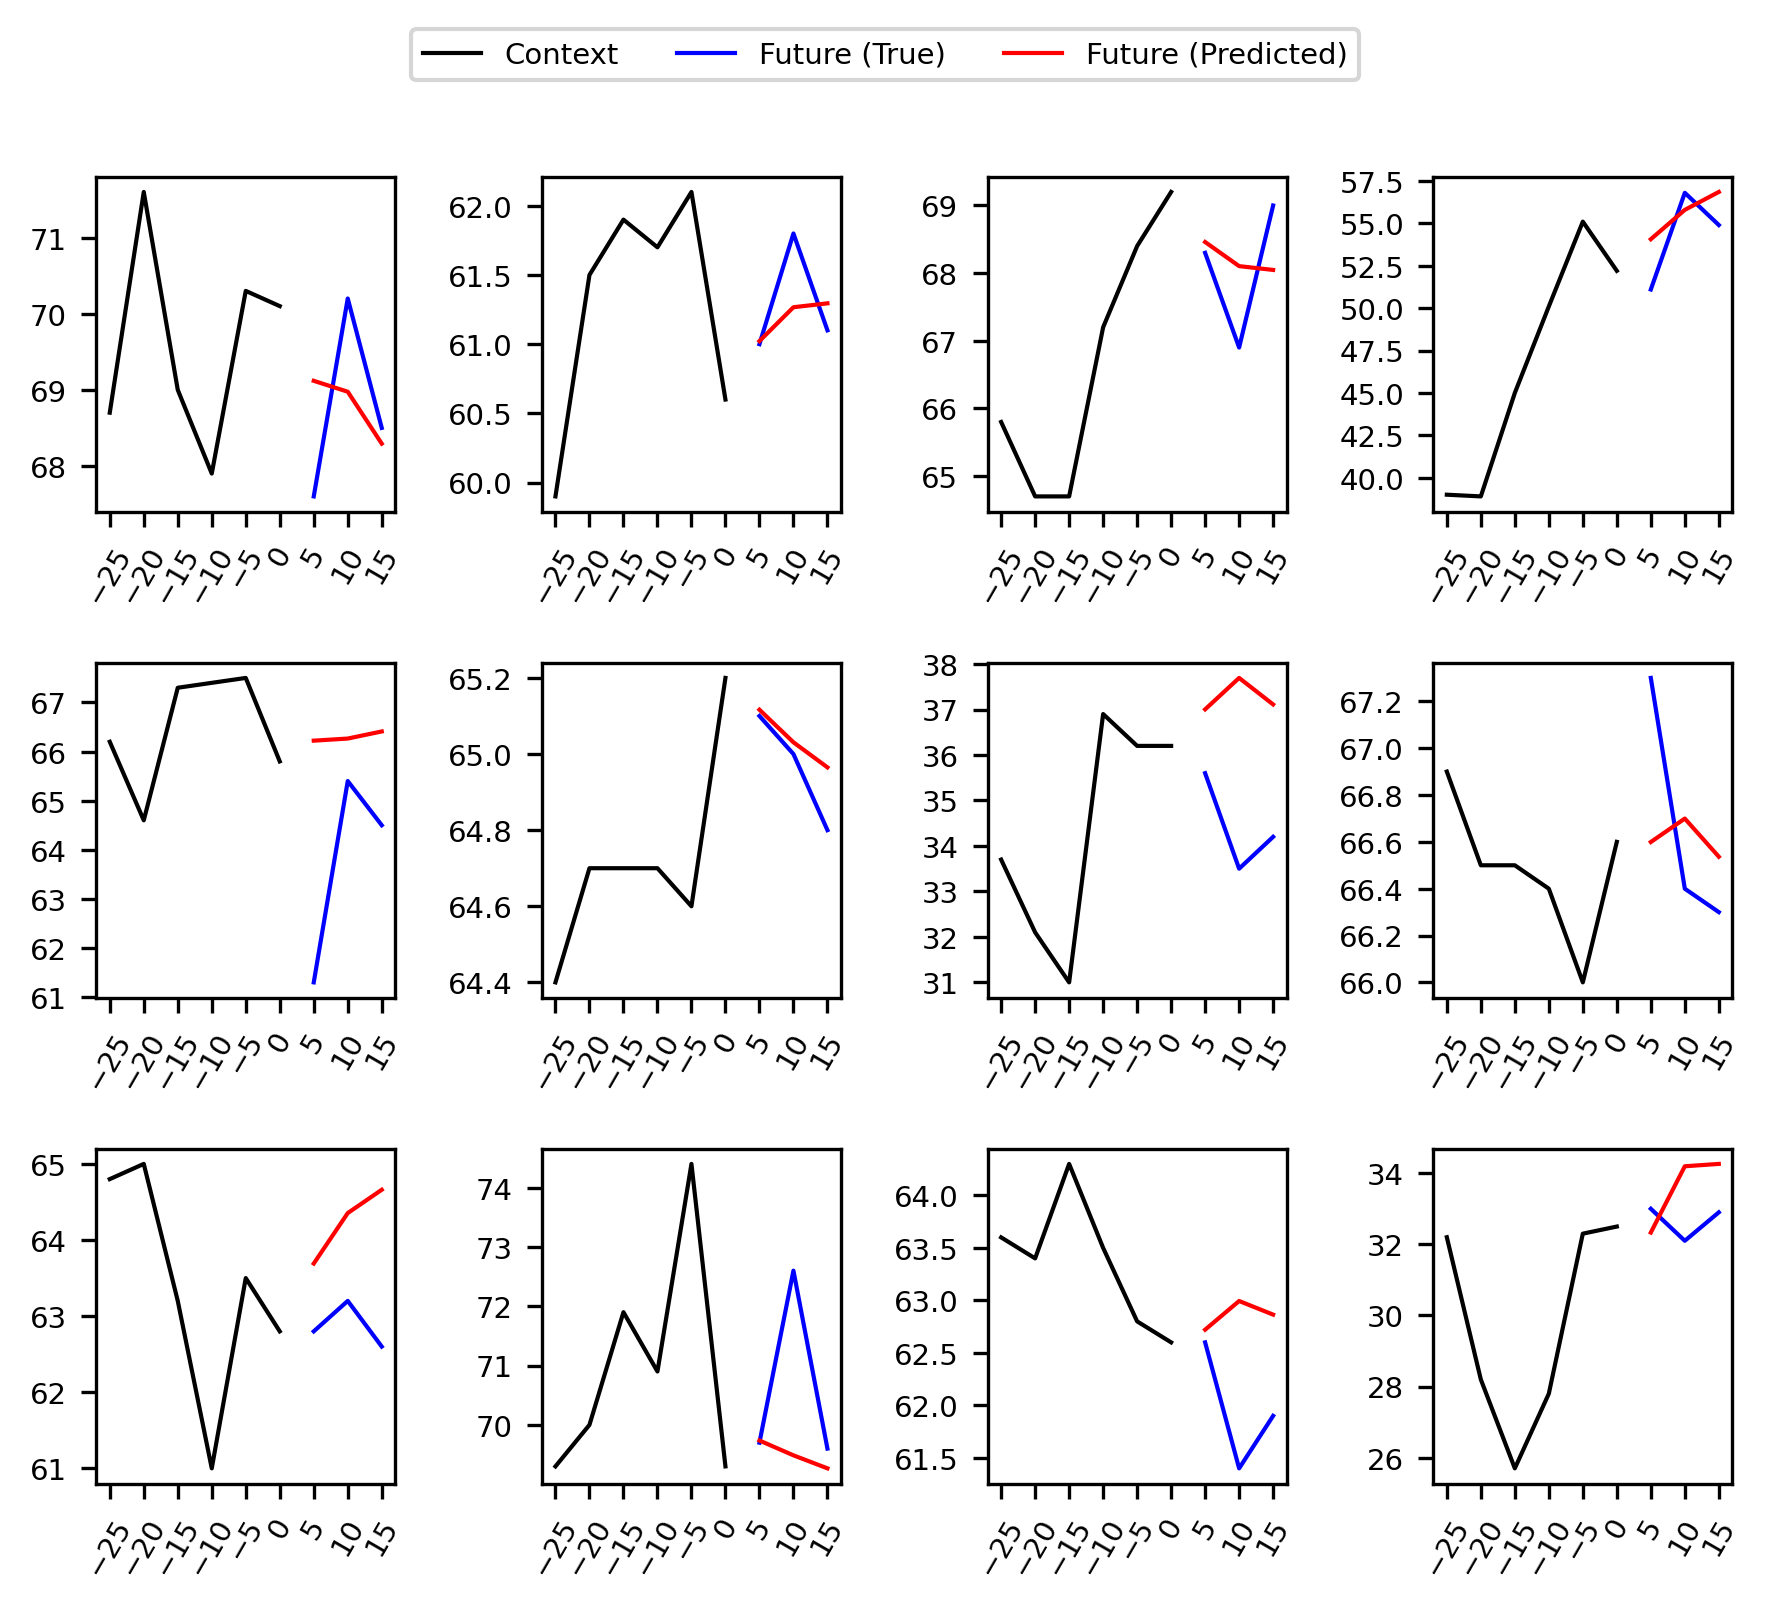

In [11]:
def display(X, y_true, y_pred, context_len, increment, no_examples):
    idxs = random.choices(range(0, y_true.shape[0]), k=no_examples)
    y_context = X.loc[idxs, [f"t{x}" for x in range(-context_len+1, 1)]].values
    y_true = y_true.loc[idxs, :].values
    
    dates_context = [(x * increment.seconds) / 60 for x in range(-context_len + 1, 1)]
    dates_pred = [(x * increment.seconds) / 60 for x in range(1, y_true.shape[1] + 1)]

    if y_pred is not None:
        y_pred = y_pred[idxs, :]
        
    no_cols = no_examples if no_examples < 4 else 4
    no_rows = math.ceil(no_examples / no_cols)
    
    fig, ax = plt.subplots(no_rows, no_cols, figsize=(6, 5))
    ax = ax.flatten()
        
    for idx0 in range(no_examples):
        ax[idx0].plot(
            dates_context, y_context[idx0], color="k", label="Context", linewidth=1)
        ax[idx0].plot(
            dates_pred, y_true[idx0], color="b", label="Future (True)", linewidth=1)
        if y_pred is not None:
            ax[idx0].plot(
                dates_pred, y_pred[idx0], color="r", 
                label="Future (Predicted)", linewidth=1)
        ax[idx0].xaxis.set_major_locator(ticker.MultipleLocator(base=5))
    
    for idx1 in range(idx0+1, no_cols * no_rows):
        fig.delaxes(ax[idx1])
      
    [label.set_rotation(60) for labels in 
      [x.get_xticklabels() for x in ax.ravel()] for label in labels]   
    [label.set_fontsize(7) for labels in 
      [x.get_xticklabels() for x in ax.ravel()] for label in labels]   
    [label.set_fontsize(7) for labels in 
      [x.get_yticklabels() for x in ax.ravel()] for label in labels]  
    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    line, label = lines_labels[0]
    fig.legend(line, label, loc="lower center", 
               bbox_to_anchor=(0, 1.02, 1, 0.2), ncol=3, fontsize=7)
    plt.tight_layout()
    plt.show()
    

display(X_test0, y_test0, y_test_pred0, context_len, increment, no_examples=12)    

Moreover, let's have a look what Shap says are the most important features. We can see that the features from neighboring sensors do not seem to help much:

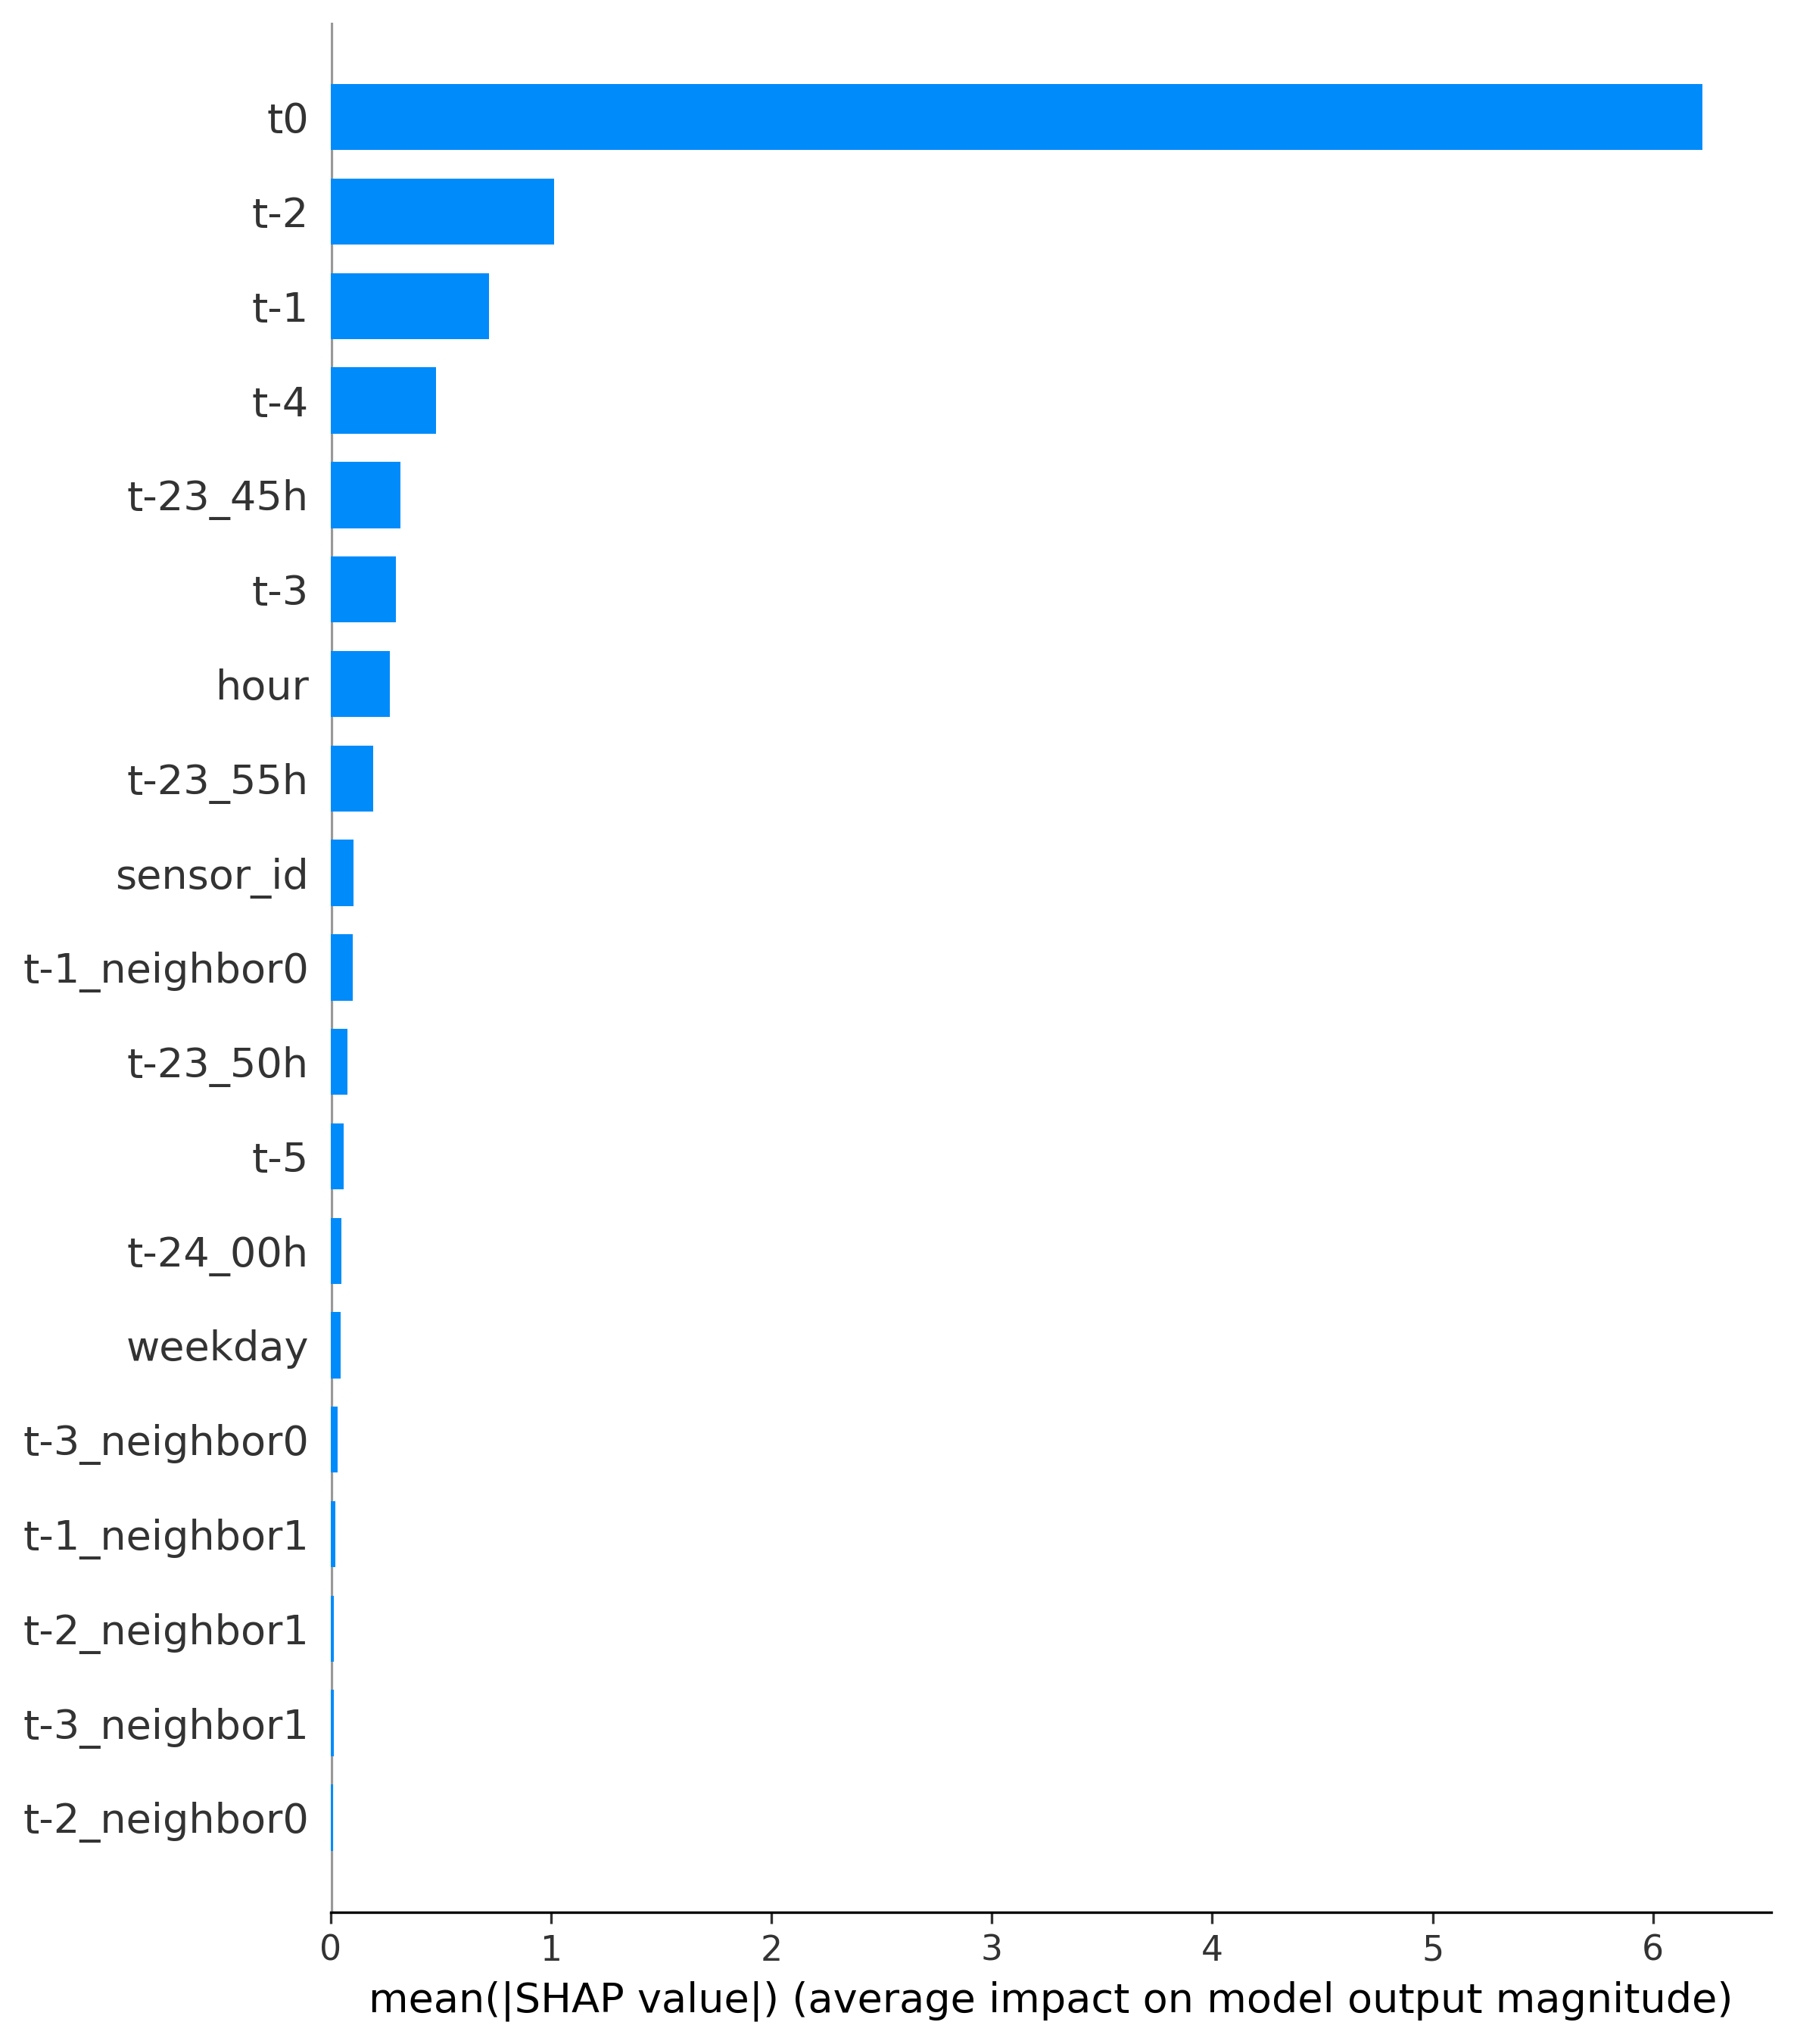

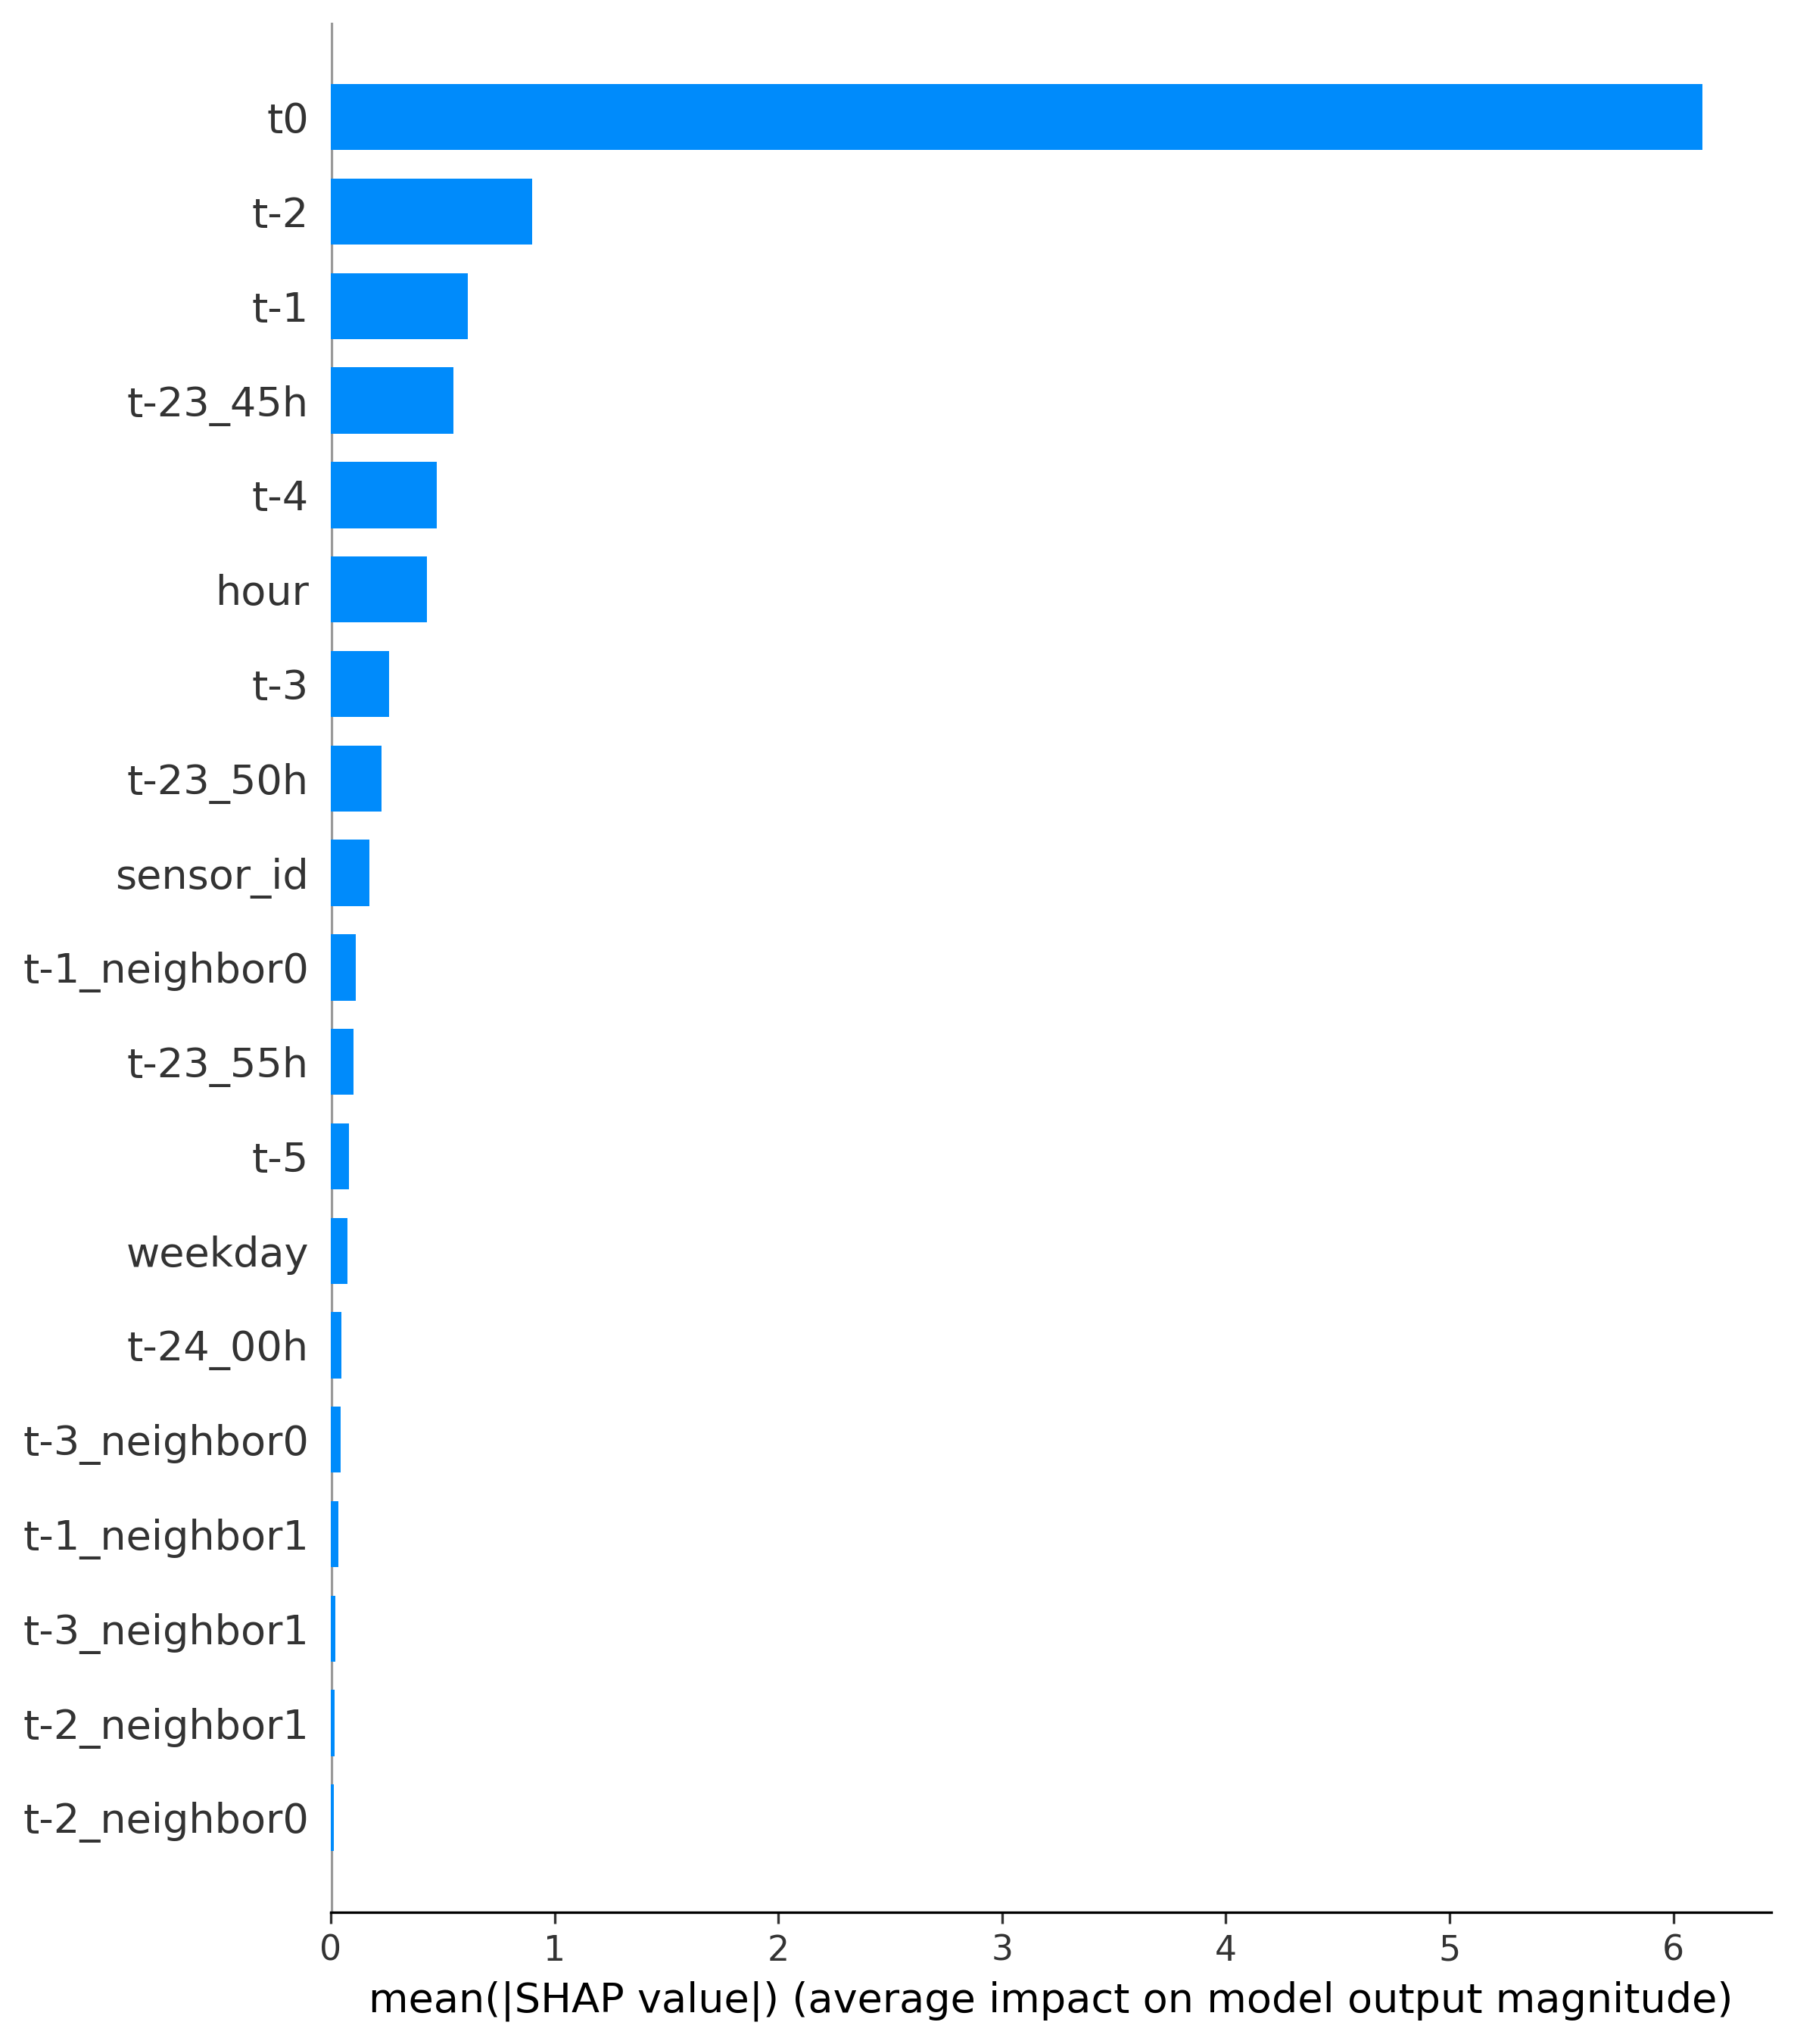

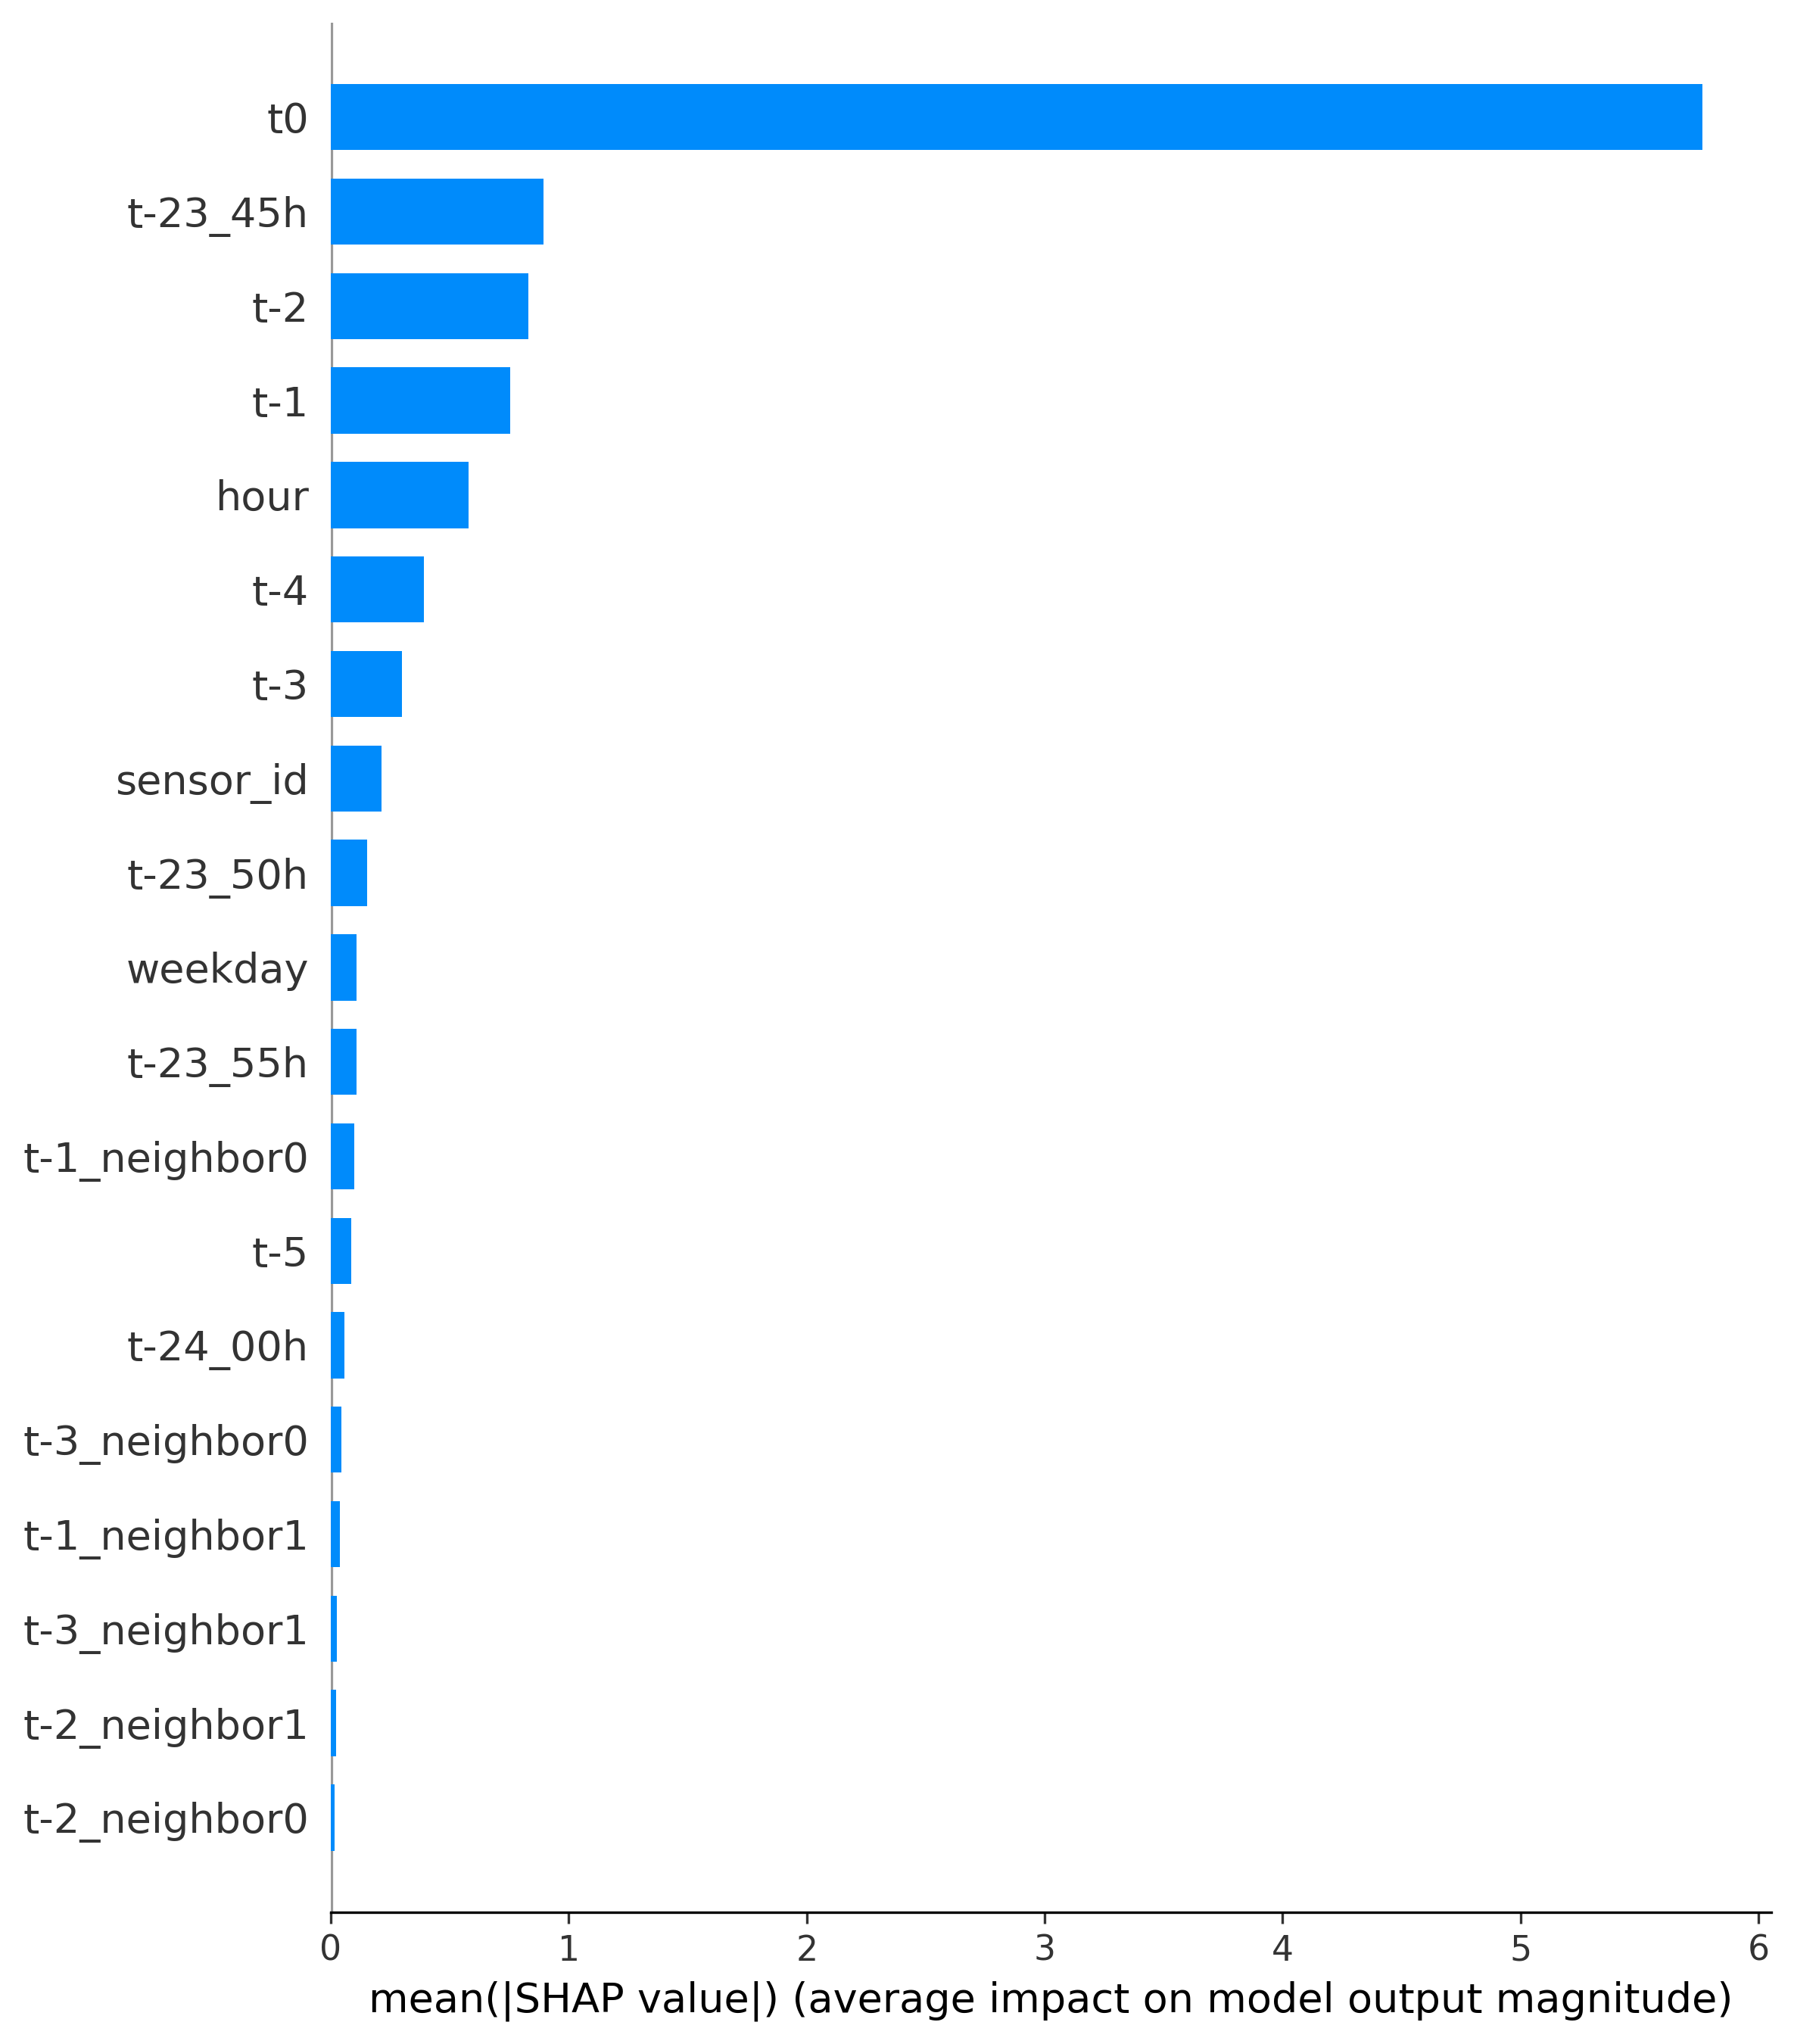

In [12]:
explainer0 = shap.TreeExplainer(models0[0])
explainer1 = shap.TreeExplainer(models0[1])
explainer2 = shap.TreeExplainer(models0[2])

tmp0 = X_test0.sample(4000)
shap_values0 = explainer0.shap_values(tmp0)
shap_values1 = explainer1.shap_values(tmp0)
shap_values2 = explainer2.shap_values(tmp0)

shap.summary_plot(shap_values0, tmp0, plot_type="bar")
shap.summary_plot(shap_values1, tmp0, plot_type="bar")
shap.summary_plot(shap_values2, tmp0, plot_type="bar")

Now let's come back to the nasty characterics of boosted trees for time series where we have to train and deploy multiple models for each time step (if we do not want the poorer performance of the recursive methods). In this medium article:
- [van de Geer, A New Method for Multi-Horizon Forecasting with Tree-based Models. **2024**](https://blog.ah.technology/a-new-method-for-multi-horizon-forecasting-with-tree-based-models-7276ae5f9636)

 the author proposes a technique coined *macking* in that only one model is trained for all time step by masking features that would not be availabe at prediction time as missing. Tree-based models have generally the ability to deal with nan values. One obvious shortcoming of this is - as the author points out himself - that "long" lags are practically never masked as missing but "short" lags are masked frequently. Here we are now going to try something similiar but more obvious/easier: We will just add the forecast horizon as an additional categorical feature. So let's have a look:

In [13]:
def convert_multihorizon_to_directly_direct(X, y):
    X = pd.concat((X for i in range(y.shape[1])))
    X["pred_horizon"] = np.array([[x] * y.shape[0] for x in y.columns]).flatten()
    X["pred_horizon"] = X["pred_horizon"].astype("category")
    y = pd.DataFrame(y.values.flatten("F"), columns=["t+x"]) 
    return X, y


X_train1, y_train1 = convert_multihorizon_to_directly_direct(X_train, y_train)  
X_val1, y_val1 = convert_multihorizon_to_directly_direct(X_val, y_val)  
X_test1, y_test1 = convert_multihorizon_to_directly_direct(X_test, y_test) 

roll_ts = 12
X_train1 = X_train1.loc[::roll_ts, :].reset_index(drop=True)
y_train1 = y_train1.loc[::roll_ts, :].reset_index(drop=True)
X_val1 = X_val1.loc[::roll_ts, :].reset_index(drop=True)
y_val1 = y_val1.loc[::roll_ts, :].reset_index(drop=True)
X_test1 = X_test1.loc[::roll_ts, :].reset_index(drop=True)
y_test1 = y_test1.loc[::roll_ts, :].reset_index(drop=True)

models1, pars1, metrics1 = train_direct_multihorizon_models(
        X_train1, y_train1, X_val1, y_val1, 1, n_trials=50)
    
tmp1 = [[f"({k}, {v:.3f})" for k, v in x.items()] for x in pars1]
_ = [print(f"Forecast horizon: {idx}\nParameters: {x}",) for idx, x in enumerate(tmp1)]
_ = [print(f"Forecast horizon: {idx}\nMAE best model: {x:.3f}",) for idx, x in enumerate(metrics1)]

y_test_pred1 = pred_multihorizon_direct(X_test1, models1)
mae_test1 = mean_absolute_error(y_test1.values, y_test_pred1)
print(f"MAE test: {mae_test1:.2f}")

Elapsed time: 173.3 min
Forecast horizon: 0
Parameters: ['(learning_rate, 0.002)', '(min_child_samples, 96.000)', '(num_leaves, 97.000)', '(max_depth, 42.000)', '(colsample_bytree, 0.541)', '(early_stopping_round, 71.000)', '(reg_alpha , 0.209)', '(reg_lambda , 0.058)']
Forecast horizon: 0
MAE best model: 1.793
Elapsed time: 2.1 min
MAE test: 1.77


Awesome. As we can see, we achieve the same performance on the test data as before but now would only have to deploy one model.